In [48]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import os


class RVL_CDIPDataset(Dataset):
    def __init__(self, split="train", transform=None, max_samples=None):
        super().__init__()
        assert split in ["train", "test"], "split must be 'train' or 'test'"
        label_files = {
            'train': 'data/RVL_CDIP/labels/train.txt',
            'test': 'data/RVL_CDIP/labels/test.txt'
        }
        root_dir = "data/RVL_CDIP/images"
        label_file = label_files[split]
        self.label_to_images = {}

        self.image_to_label = {}
        self.all_images = []

        with open(label_file, 'r') as f:
            for i, line in enumerate(f):
                if max_samples is not None and i >= max_samples:
                    break
                path, label = line.strip().split()
                full_path = os.path.join(root_dir, path)
                label = int(label)
                if label not in self.label_to_images:
                    self.label_to_images[label] = []
                self.label_to_images[label].append(full_path)
                self.image_to_label[full_path] = label
                self.all_images.append((full_path, label))

        self.labels = list(self.label_to_images.keys())
        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, index):
        image_path, label = self.all_images[index]
        image = Image.open(image_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

In [49]:
from torchvision.transforms import transforms

IMAGE_SIZE = (180, 180)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # resize to a standard size
    transforms.ToTensor()  # convert to tensor
])
MAX_SAMPLES = 2500
train_dataset = RVL_CDIPDataset(split="train", transform=transform, max_samples=MAX_SAMPLES)

In [50]:
class_names = {
    0: "letter",
    1: "form",
    2: "email",
    3: "handwritten",
    4: "advertisement",
    5: "scientific report",
    6: "scientific publication",
    7: "specification",
    8: "file folder",
    9: "news article",
    10: "budget",
    11: "invoice",
    12: "presentation",
    13: "questionnaire",
    14: "resume",
    15: "memo"
}

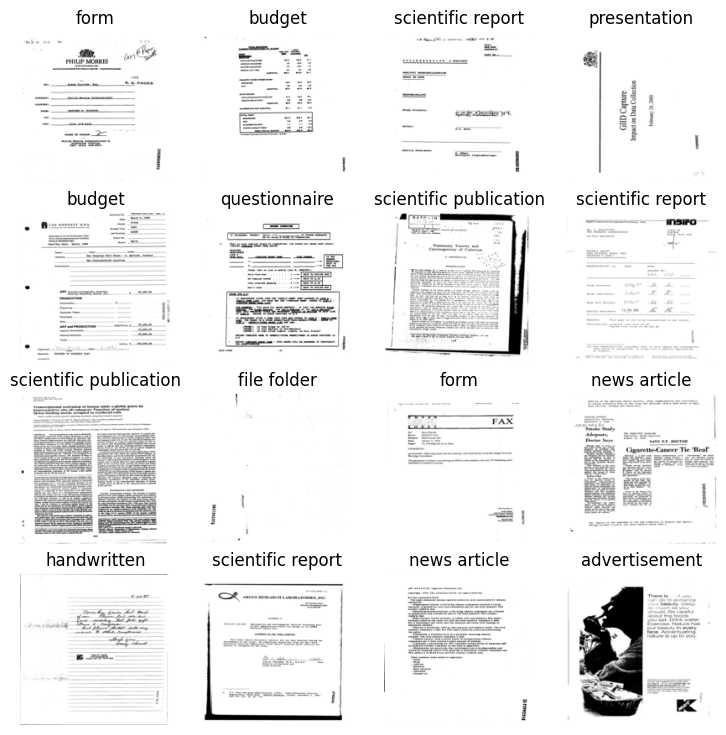

In [51]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [52]:
import torch
from torch import nn


class ConvNetwork(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, image_size=(100, 100)):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=11, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_units, hidden_units, kernel_size=7, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_units, hidden_units, kernel_size=5, padding=1, stride=1),
            nn.ReLU(),
        )

        with torch.inference_mode():
            dummy_input = torch.zeros(1, input_shape, *image_size)
            dummy_output = self.cnn(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape),  # Final embedding size
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x


net = ConvNetwork(input_shape=1, hidden_units=16, output_shape=len(class_names), image_size=IMAGE_SIZE)

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

In [54]:
from tqdm.auto import tqdm


def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: nn.Module,
               optimizer: torch.optim.Optimizer):
    train_loss = 0.0
    model.train()

    dataloader_progress = tqdm(dataloader, desc="Training...")

    for i, (X, y) in enumerate(dataloader_progress):
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_train_loss = train_loss / (i + 1)
        dataloader_progress.set_postfix(avg_loss=current_train_loss)

    train_loss /= len(dataloader)
    print(f"train loss: {train_loss:.5f}")


In [55]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              criterion: nn.Module):
    test_loss = 0.0
    model.eval()
    dataloader_progress = tqdm(dataloader, desc="Testing...")
    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader_progress):
            y_pred = model(X)
            loss = criterion(y_pred, y)
            test_loss += loss.item()

            current_test_loss = test_loss / (i + 1)
            dataloader_progress.set_postfix(avg_loss=current_test_loss)

        test_loss /= len(dataloader)
        print(f"test loss: {test_loss:.5f}")

In [58]:
test_dataset = RVL_CDIPDataset(split="test", transform=transform, max_samples=MAX_SAMPLES)

train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=32)

In [59]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

start_time = timer()
# train and test model
epochs = 1
for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}")
    train_step(model=net, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer)
    test_step(net, test_dataloader, criterion)

end_time = timer()
total_time = end_time - start_time
print(f"trained for {total_time} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0


Training...:   0%|          | 0/79 [00:00<?, ?it/s]

train loss: 2.72555


Testing...:   0%|          | 0/79 [00:00<?, ?it/s]

test loss: 2.69390
trained for 34.9897101999959 seconds
